In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle

## Load Dataste

In [6]:
df = pd.read_csv('../data/final_data.csv')
df.head()

,brands,product_name,categories,countries,food_groups_tags,food_groups,ingredients_text,category_name,country,processed_ingredients,health_label
0,"Mutti,POLPA",pulpe de tomates,"Pflanzliche Lebensmittel und Getränke,Pflanzli...","Australien,Österreich,Belgien,Kanada,Frankreic...","['en:fruits-and-vegetables', 'en:vegetables']",en:vegetables,"tomatoes 99.8%, salt",Plant-based foods and beverages,canada,"tomatoes 99.8%, salt",healthy
1,"Maïzena, Unilever",Maizena Fleur de Maïs Sans Gluten 400g,"Plant-based foods and beverages, Plant-based f...","Belgique, Canada, France, Martinique, La Réuni...","['en:cereals-and-potatoes', 'en:cereals']",en:cereals,Amidon de maïs.,Plant-based foods and beverages,canada,amidon de maïs.,healthy
2,Barilla,Lasagne all'uovo,"Cibi e bevande a base vegetale, Cibi a base ve...","Belgium,Canada,Croatia,France,Germany,Greece,H...","['en:cereals-and-potatoes', 'en:cereals']",en:cereals,"Semola di grano duro, uova fresche di categori...",Plant-based foods and beverages,canada,"semola di grano duro, uova fresche di categori...",healthy
3,Tipiak,Fine chapelure de pain,"Aliments et boissons à base de végétaux,Alimen...","Canada,France","['en:cereals-and-potatoes', 'en:bread']",en:bread,"Farine de blé (gluten), sel, levure, Traces po...",Plant-based foods and beverages,canada,"farine de blé (gluten), sel, levure, traces po...",healthy
4,"Zespri,Sungold,Catania,ALDI Zespri",Kiwi Sungold,"Aliments et boissons à base de végétaux,Alimen...","Belgique,Canada,France,Allemagne,Pologne,Espag...","['en:fruits-and-vegetables', 'en:fruits']",en:fruits,Kiwifruit,Plant-based foods and beverages,canada,kiwifruit,healthy


### Model Preparation

In [7]:
X = df['processed_ingredients']
y= df['health_label']


#### Baseline Accuracy


In [8]:
y.value_counts(normalize = True)# unbalance class so we need to stratify

health_label
healthy        0.936023
not healthy    0.063977
Name: proportion, dtype: float64

#### Train test split

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

### Logistic Regression

In [10]:
logr_pipeline = Pipeline(
    [
        ('cvec',CountVectorizer()),
        ('logr',LogisticRegression())
]
)
grid_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'cvec__max_df': [0.75, 0.85, 1.0],      # Ignore very frequent words
    'cvec__min_df': [1, 2, 5],              # Ignore very infrequent words
    'cvec__max_features': [None, 1000,5000, 10000],  # Limit on the number of features

    'logr__C': [0.01, 0.1, 1.0, 10],        # Regularization strength
    'logr__penalty': ['l2'],                # L2 regularization (Ridge)
    'logr__solver': ['lbfgs', 'liblinear']  # Solvers suitable for small datasets
}

gs_logr = GridSearchCV(logr_pipeline,param_grid=grid_params,n_jobs=-1)
gs_logr.fit(X_train,y_train)
print(f' Best parameters:{gs_logr.best_params_}')
print(f' Best score:{gs_logr.best_score_}')

 Best parameters:{'cvec__max_df': 0.75, 'cvec__max_features': 10000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'logr__C': 10, 'logr__penalty': 'l2', 'logr__solver': 'liblinear'}
 Best score:0.9907753223404813


In [11]:
gs_logr.best_estimator_.named_steps['logr'].intercept_
gs_logr.best_estimator_.named_steps['logr'].coef_

array([[-0.94092293,  0.01230099,  0.0430419 , ..., -0.01595785,
        -0.04043393, -0.03904433]])

In [12]:

#Logistic Regression Coefficients 
print(f"Logistic Regression Intercept: {gs_logr.best_estimator_.named_steps['logr'].intercept_}")
print(f"Logistic Regression Coefficients: {gs_logr.best_estimator_.named_steps['logr'].coef_}")
coefficients=gs_logr.best_estimator_.named_steps['logr'].coef_.ravel()
vectorizer = gs_logr.best_estimator_.named_steps['cvec']
feature_names = vectorizer.get_feature_names_out()
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df.head(),coefficients_df.tail(),
top_features = coefficients_df.head()
bottom_features = coefficients_df.tail()


print(f"Top 5 positive coefficients:\n{top_features}")
print(f"Top 5 negative coefficients:\n{bottom_features}")

Logistic Regression Intercept: [-7.82901641]
Logistic Regression Coefficients: [[-0.94092293  0.01230099  0.0430419  ... -0.01595785 -0.04043393
  -0.03904433]]
Top 5 positive coefficients:
                   Feature  Coefficient
1639           carrageenan     8.495408
1148                   bht     6.249143
5461         metabisulfite     4.926567
8547             sucralose     4.551041
5684  monosodium glutamate     4.163503
Top 5 negative coefficients:
                  Feature  Coefficient
7322  purified carbonated    -1.770601
5464                   mg    -1.987640
4767            juice and    -2.815921
7150         preservative    -2.876583
7154        preservatives    -3.319173


In [13]:
preds = gs_logr.predict(X_test)

logr_train_accuracy = round(gs_logr.score(X_train, y_train), 2)
logr_test_accuracy = round(gs_logr.score(X_test, y_test), 2)

logr_train_misclassification_rate = round(1 - logr_train_accuracy, 2)
logr_test_misclassification_rate = round(1 - logr_test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {logr_train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {logr_test_accuracy}')

print(f'Training Misclassification Rate: {logr_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {logr_test_misclassification_rate}')
#specificity

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

logr_spec = tn / (tn + fp)
print(f'Logistic Regression specificity: {round(logr_spec,2)}')
# recall

logr_recall = tp / (tp + fn)

print(f'Logistic Regression recall: {round(logr_recall,2)}')
logr_f1_tech = f1_score(y_test, preds, pos_label='not healthy')
logr_f1_gad = f1_score(y_test, preds, pos_label='healthy')

print(f'Logistic Regression F1_score not healthy: {round(logr_f1_tech,2)}')
print(f'Logistic Regression F1_score healthy : {round(logr_f1_gad,2)}')

Training Accuracy of Logistic Regression with Count Vectorizer: 1.0
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.99
Training Misclassification Rate: 0.0
Testing Misclassification Rate: 0.01
Logistic Regression specificity: 1.0
Logistic Regression recall: 0.93
Logistic Regression F1_score not healthy: 0.94
Logistic Regression F1_score healthy : 1.0


In [14]:
#classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      6021
 not healthy       0.94      0.93      0.94       411

    accuracy                           0.99      6432
   macro avg       0.97      0.96      0.97      6432
weighted avg       0.99      0.99      0.99      6432



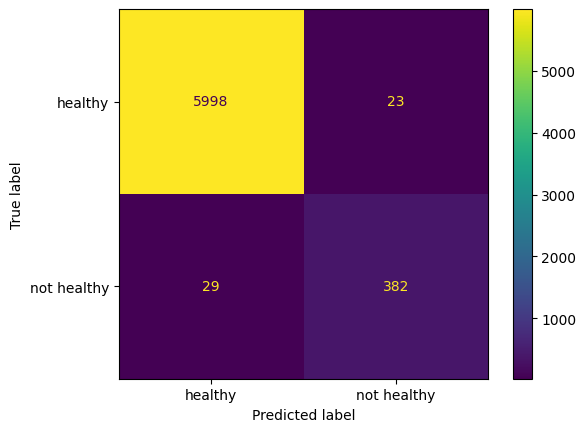

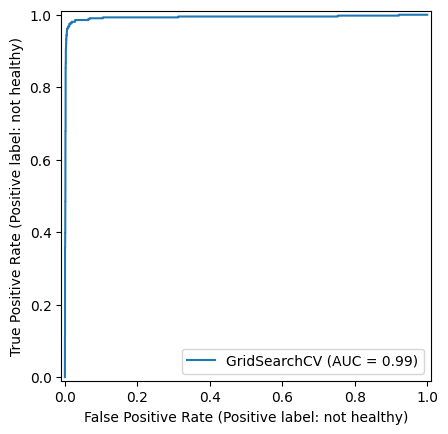

In [15]:
ConfusionMatrixDisplay.from_estimator(gs_logr,X_test,y_test);
RocCurveDisplay.from_estimator(gs_logr,X_test,y_test);

### Neural Network

In [16]:
pipe_nb =Pipeline(
    [
        ('tf-idf',TfidfVectorizer()),
        ('nb',MultinomialNB())
    ]
)


grid_params = {
    'tf-idf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tf-idf__stop_words': [None, 'english'],
    'tf-idf__max_features': range(2000, 4001, 1000),
    'tf-idf__min_df': [2, 4],
    'tf-idf__max_df': np.linspace(0.9, 0.99, 5),
    'nb__alpha': [0.1, 0.5, 1.0]            # Smoothing parameter for Naive Bayes
   
}

gs_nb = GridSearchCV(pipe_nb, grid_params, n_jobs=-1, cv=5)
gs_nb.fit(X_train, y_train)

print(f' Best parameters:{gs_nb.best_params_}')
print(f' Best score:{gs_nb.best_score_}')

 Best parameters:{'nb__alpha': 1.0, 'tf-idf__max_df': np.float64(0.9), 'tf-idf__max_features': 3000, 'tf-idf__min_df': 2, 'tf-idf__ngram_range': (1, 1), 'tf-idf__stop_words': None}
 Best score:0.9610801477469396


In [17]:
pred_nb = gs_nb.predict(X_test)

nb_train_accuracy = round(gs_nb.score(X_train, y_train), 2)
nb_test_accuracy = round(gs_nb.score(X_test, y_test), 2)

nb_train_misclassification_rate = round(1 - nb_train_accuracy, 2)
nb_test_misclassification_rate = round(1 - nb_test_accuracy, 2)

print(f'Training Accuracy of Naive bayes  with TF-IDF Vectorizer: {nb_train_accuracy}')
print(f'Testing Accuracy of Naive bayes  with TF-IDF Vectorizer: {nb_test_accuracy}')

print(f'Training Misclassification Rate: {nb_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {nb_test_misclassification_rate}')
# Perform cross-validation on the entire training data using the final model
cross_val_scores = cross_val_score(gs_nb.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)

# Calculate the mean cross-validation score
mean_cross_val_score = cross_val_scores.mean()
print(f'cross val score of Naive Bayes :{mean_cross_val_score}')

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred_nb).ravel()

nb_spec = tn / (tn + fp)
print(f'Naive Bayes specificity: {round(nb_spec,2)}')
# recall

nb_recall = tp / (tp + fn)

print(f'Naive Bayes recall: {round(nb_recall,2)}')
nb_f1_tech = f1_score(y_test, pred_nb, pos_label='not healthy')
nb_f1_gad = f1_score(y_test, pred_nb, pos_label='healthy')


print(f'Naive bayes F1_score not healthy: {round(nb_f1_tech,2)}')
print(f'Naive bayes  F1_score healthy : {round(nb_f1_gad,2)}')

Training Accuracy of Naive bayes  with TF-IDF Vectorizer: 0.96
Testing Accuracy of Naive bayes  with TF-IDF Vectorizer: 0.96
Training Misclassification Rate: 0.04
Testing Misclassification Rate: 0.04
cross val score of Naive Bayes :0.9610801477469396
Naive Bayes specificity: 0.97
Naive Bayes recall: 0.7
Naive bayes F1_score not healthy: 0.67
Naive bayes  F1_score healthy : 0.98


In [18]:
#classification report
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

     healthy       0.98      0.97      0.98      6021
 not healthy       0.65      0.70      0.67       411

    accuracy                           0.96      6432
   macro avg       0.81      0.83      0.82      6432
weighted avg       0.96      0.96      0.96      6432



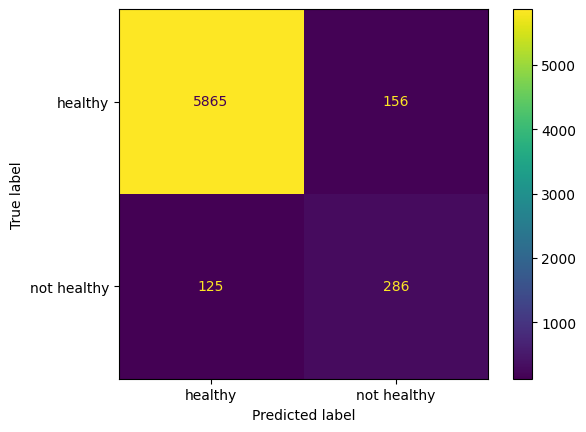

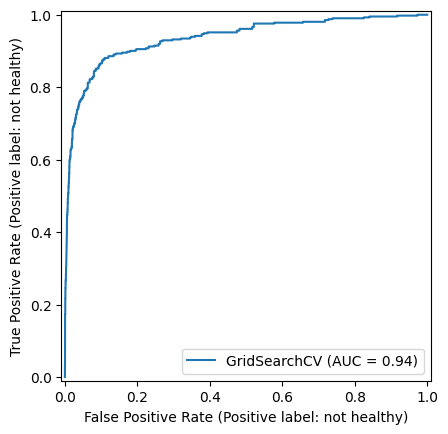

In [19]:
ConfusionMatrixDisplay.from_estimator(gs_nb,X_test,y_test);
RocCurveDisplay.from_estimator(gs_nb,X_test,y_test);

In [22]:

with open('../models/foodclassifier.pkl', 'wb') as pickle_out:
    pickle.dump(gs_nb.best_estimator_, pickle_out)
